张峪齐 3200105176

### 第一题

#### 题目

房价预测

#### 解答

##### 导入依赖

In [2]:
import pandas
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

##### 读取数据

In [3]:

#读取csv数据
train_data = pandas.read_csv("kaggle_house_pred_train.csv")
test_data = pandas.read_csv("kaggle_house_pred_test.csv")
#把去掉id的数据拼在一起，去掉id的目的是为了防止模型通过记住编号得到对应房价。
all_features = pandas.concat(( train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
print("train_data.shape:",train_data.shape)
print("test_data.shape:",test_data.shape)
print("all_features:",all_features.shape)
print(train_data.iloc[:5,:8])

train_data.shape: (1460, 81)
test_data.shape: (1459, 80)
all_features: (2919, 79)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape
0   1          60       RL         65.0     8450   Pave   NaN      Reg
1   2          20       RL         80.0     9600   Pave   NaN      Reg
2   3          60       RL         68.0    11250   Pave   NaN      IR1
3   4          70       RL         60.0     9550   Pave   NaN      IR1
4   5          60       RL         84.0    14260   Pave   NaN      IR1


##### 处理缺省值和属性

In [4]:
#提取全是数字的特征名字
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#对数据做标准化处理,对应位置赋值
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.
std()))
# 在标准化数据之后，将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
#‘Dummy_na=True‘ 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
# pandas.get_dummies把特征为类别值或离散值分成每一个特征为一个类别。
all_features = pandas.get_dummies(all_features, dummy_na = True)
print("all_features.shape:",all_features.shape)
all_features.head()

all_features.shape: (2919, 331)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


##### 分成训练数据和测试数据

In [5]:
#把数据分成训练数据和测试数据
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype = torch.float32)
print("train_features.shape:", train_features.shape)
print("train_features.shape:", test_features.shape)
print("train_labels:", train_labels.shape)

train_features.shape: torch.Size([1460, 331])
train_features.shape: torch.Size([1459, 331])
train_labels: torch.Size([1460, 1])


### Test

In [13]:
class Net(nn.Module):
  
    def __init__(self, features):
        super(Net, self).__init__()
        
        self.linear_relu1 = nn.Linear(features, 128)
        self.linear_relu2 = nn.Linear(128, 256)
        self.linear_relu3 = nn.Linear(256, 256)
        self.linear_relu4 = nn.Linear(256, 256)
        self.linear5 = nn.Linear(256, 1)
        
    def forward(self, x):
        
        y_pred = self.linear_relu1(x)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu2(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu3(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu4(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear5(y_pred)
        return y_pred

model = Net(features=train_features.shape[1])

# 使用均方误差作为损失函数
criterion = nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

losses = []
#animator = d2l.Animator(xlabel='epoch', xlim=[1, 500], ylim=[0.0, 1.0],legend=['train loss'])
# 训练500轮
for t in range(5000):
    y_pred = model(train_features)
    
    loss = criterion(y_pred, train_labels)
    print(t, loss.item())
    losses.append(loss.item())
    
    #animator.add(t, loss.item())
    if torch.isnan(loss):
        break
    
    # 将模型中各参数的梯度清零。
    # PyTorch的backward()方法计算梯度会默认将本次计算的梯度与缓存中已有的梯度加和。
    # 必须在反向传播前先清零。
    optimizer.zero_grad()
    
    # 反向传播，计算各参数对于损失loss的梯度
    loss.backward()
    
    # 根据刚刚反向传播得到的梯度更新模型参数
    optimizer.step()


0 39039258624.0
1 22330974208.0
2 426850385920.0
3 13100753920.0
4 37139922944.0
5 39012360192.0
6 39038095360.0
7 39037702144.0
8 39030763520.0
9 38979231744.0
10 38732939264.0
11 37913960448.0
12 35799146496.0
13 31169355776.0
14 22627473408.0
15 10154149888.0
16 3365846272.0
17 20026091520.0
18 8163047936.0
19 1846638592.0
20 4077673728.0
21 7646039040.0
22 9543980032.0
23 9308614656.0
24 7215307264.0
25 3988648192.0
26 1387685888.0
27 2149845504.0
28 5239582720.0
29 4689364480.0
30 1910794368.0
31 966275648.0
32 1849606400.0
33 2906728192.0
34 3193535488.0
35 2583490816.0
36 1518937216.0
37 815055872.0
38 1123317888.0
39 1774232192.0
40 1479783168.0
41 793360064.0
42 883438720.0
43 1279432832.0
44 1099889024.0
45 699313600.0
46 707011968.0
47 985687488.0
48 937108352.0
49 664302144.0
50 632280896.0
51 786405632.0
52 798995968.0
53 646807616.0
54 577476544.0
55 669753408.0
56 698036480.0
57 595102976.0
58 543405952.0
59 595989056.0
60 622778624.0
61 566840256.0
62 519008640.0
63 544

## ??

##### 数据分批

In [7]:
batch_size = 32

dataset = torch.utils.data.TensorDataset(train_features, train_labels)

train_loader = torch.utils.data.DataLoader(dataset, # 数据
    batch_size = batch_size, # 每个batch大小
    shuffle = True, # 是否打乱数据
    num_workers = 0, # 工作线程
    pin_memory = True)

print(f"每一批{len(next(iter(train_loader))[0])}个，一共{len(train_loader)}批")

#for X, y in train_loader:
#    print(X.shape, y.shape)

每一批32个，一共46批


##### 定义网络

In [8]:
#class MyNet(nn.Module):
#    def __init__(self, in_put, hidden, hidden1, out_put):
#        super().__init__()
#        self.in_put=in_put #接收331维的输入，输出1024维度
#        self.hidden=hidden
#        self.hidden1=hidden1 # 接收256维度，输出1维(房价)
#        self.out_put=out_put
        # Codes

#    def forward(self, data):
        # Codes
#        return self.out_put(self.hidden1(self.hidden(self.in_put(data))))
net = nn.Sequential(nn.Linear(331,256),nn.ReLU(),nn.Linear(256,1))
#net=MyNet(nn.Linear(331,1024),nn.ReLU(),nn.Linear(1024,1024),nn.Linear(1024,1)) 


##### 初始化神经网络

In [9]:
#初始化参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

net.apply(init_weights);

#将模型放到GPU上
def try_gpu(i=0):  #尝试获取gpu设备
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

#net = net.to(device=try_gpu())

#损失函数loss(xi,yi)=(xiyi)2
loss = nn.MSELoss(reduction="mean")

#梯度优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

##### 定义loss图像绘图函数

##### 训练神经网络并绘图

In [10]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    #if isinstance(net, torch.nn.Module):
    net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        #将batch移到gpu上
        #X, y = X.to(device), y.to(device)
        
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, loss, num_epochs, updater): #@save

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
    legend=['train loss', 'train acc'])
    #epoch_count=0
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        train_loss,train_acc = train_metrics
        print(f"train_loss= {train_loss} , train_acc={train_acc}")
        #animator.add(epoch + 1, train_metrics )
        #print(f"{epoch_count} epoches trained")
        #epoch_count+=1
    train_loss,train_acc = train_metrics
    #assert train_loss < 0.5, train_loss
    #assert train_acc <= 1 and train_acc > 0.7, train_acc

train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_loss= nan , train_acc=0.0
train_lo

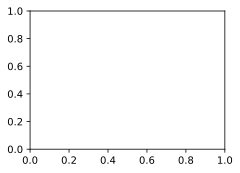

In [11]:
num_epochs=150
train(net,train_loader,loss,num_epochs,trainer)

##### 测试神经网络生成提交数据

In [12]:


def test(model,test_features):
    test_features = test_features.to(device=try_gpu())
    preds = model(test_features).detach().to("cpu").numpy()
    print(preds.squeeze().shape)

    #pandas.Series 创建新维度
    test_data['SalePrice'] = pandas.Series(preds.squeeze())
              
    #axis选择拼接的维度
    return pandas.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
